#Forest Cover Prediction
###By Kevin Allen

The first thing we need to do is import the data and reformat it to an ndarray to use for scikit-learn.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import export_graphviz

# SK-learn libraries for learning.
from sklearn.dummy import DummyClassifier


In [122]:
# get the feature names from the first row of the train data
with open("train.csv","r") as f:
    reader = csv.reader(f)
    feature_names = reader.next()
# read the train and test data
train_data = np.loadtxt(open("train.csv","rb"),delimiter=",",skiprows=1)
test_data = np.loadtxt(open("test.csv","rb"),delimiter=",",skiprows=1)

# remove CoverType from the feature names and training data
feature_names = feature_names[:-1]
all_train, all_train_labels = train_data[:,:-1], train_data[:,-1]

# shuffle the training data and divide into train and dev
examples = all_train.shape[0]
shuffle = np.random.permutation(np.arange(examples))
all_train, all_train_labels = all_train[shuffle], all_train_labels[shuffle]
train_data, train_labels = all_train[:.8*examples], all_train_labels[:.8*examples]
dev_data, dev_labels = all_train[.8*examples:], all_train_labels[.8*examples:]

print 'There are %s features, %s training examples, %s dev examples' % \
    (train_data.shape[1], train_data.shape[0], dev_data.shape[0])

covertypes = ["Spruce/Fir","Lodgepole Pine","Ponderosa Pine",
              "Cottonwood/Willow","Aspen","Douglas-fir","Krummholz"]

There are 55 features, 12096 training examples, 3024 dev examples


In [5]:
# create a baseline estimate by predicting a random label
clf = DummyClassifier(strategy='uniform')
clf.fit(train_data, train_labels)
predictions = clf.predict(test_data)

with open("predictions.csv", "wb") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Id','Cover_Type'])
    for id, prediction in zip(test_data[:,0], predictions):
        writer.writerow([int(id), int(prediction)])



In [128]:
print [col for col in train.columns if "Soil_Type" in col]

['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']


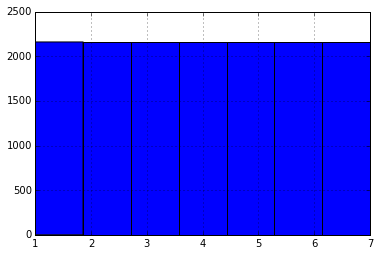

In [81]:
# # plot the features to see how they are distributed and scaled
# train.ix[:,0:11].hist(figsize=(16,12),bins=50)
# plt.show()
train = pd.read_csv('train.csv')
train['Cover_Type'].hist(bins=7)


In [ ]:
# First try a bunch of classifiers, both with and without feature standardization

# first need to scale data to zero mean and unit variance
scaler = StandardScaler().fit(train_data)
strdz_train = scaler.transform(train_data)
strdz_dev = scaler.transform(dev_data)

names = ["Logistic Regression","Nearest Neighbors", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear SVM", "RBF SVM"]
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
]

for name, clf in zip(names, classifiers):
    print name
    # SVM classifiers don't work without feature standardization
    if (name != 'Linear SVM' and name != 'RBF SVM'):
        clf.fit(X_train, y_train)
        score = clf.score(dev_data, dev_labels)
        print 'Without feature standardization, score = ', score
    st = time.time()
    clf.fit(strdz_train, train_labels)
    train_time = time.time() - st
    st = time.time()
    score = clf.score(strdz_dev, dev_labels)
    predict_time = time.time() - st
    print 'With feature standardization, score = ', score
    print 'Training time: %.3f' % train_time
    print 'Prediction time: %.3f' % predict_time
    print

###Why does nearest neighbors work so well?
It is a natural multiclass algorithm. 

Removing the following features:
Wilderness_Area2
Soil_Type7
Soil_Type8
Soil_Type9
Soil_Type15
Soil_Type21
Soil_Type25
Soil_Type27
Soil_Type28
Soil_Type34
Soil_Type36
0.662037037037
Removing the following features:
Soil_Type7
Soil_Type8
Soil_Type15
Soil_Type25
Soil_Type28
Soil_Type36
0.647817460317
Removing the following features:
Soil_Type7
Soil_Type8
Soil_Type15
Soil_Type25
0.668981481481
Removing the following features:
Soil_Type7
Soil_Type8
Soil_Type15
Soil_Type25
0.662367724868
Removing the following features:
Soil_Type7
Soil_Type8
Soil_Type15
Soil_Type25
0.65873015873


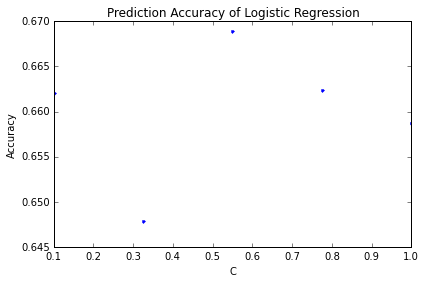

In [86]:
# Feature selection using logistic regression and regularization

accuracies = []
c_values = np.linspace(0.1,1,5)
for index, c in enumerate([c_values]):
    # train a model
    logreg_l1 = LogisticRegression(penalty='l1', C=c)
    logreg_l1.fit(train_data, train_labels)
    
    # find the indexes of the nonzero coefficients
    nz = np.array(list(set(logreg_l1.coef_.nonzero()[1])))
    # create array of indexes of zero coefficients
    z = np.setxor1d(np.arange(0,55),nz)
    print 'Removing the following features:'
    for feature in z:
        print feature_names[feature]
    mtrain = np.delete(train_data, z, 1)
    mdev = np.delete(dev_data, z, 1)

    # train a model and check accuracy
    logreg_l2 = LogisticRegression(penalty='l2')
    logreg_l2.fit(mtrain, train_labels)
    score = logreg_l2.score(mdev, dev_labels)
    print score
    accuracies.append(score)

# plot the data
fig, ax = plt.subplots()
ax.set_title('Prediction Accuracy of Logistic Regression')
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
ax.plot(c_values, accuracies, 'b.')
plt.tight_layout()
plt.show()


It looks like feature selection has little impact when it comes to logistic regression...<br/><br/>

In [348]:
# Instead of doing feature selection, look at relative weights of features

# first need to scale data to zero mean and unit variance
scaler = StandardScaler().fit(train_data)
strdz_train = scaler.transform(train_data)
strdz_dev = scaler.transform(dev_data)

logreg = LogisticRegression(penalty='l2')
logreg.fit(strdz_train, train_labels)
top_features = []
for coef, feature in sorted(zip(sum(logreg.coef_**2),feature_names), 
                            key=lambda x: x[0], reverse=True):
    index = feature_names.index(feature)
    print "%2s %.4f %s" % (index, coef, feature)
    top_features.append(index)

top = top_features[:15]
mask = np.zeros(train_data.shape[1], dtype=bool)
mask[top] = True
mfeatures = [f for f in itertools.compress(feature_names, mask)]
print mfeatures

 1 60.7803 Elevation
 9 24.5057 Hillshade_3pm
14 15.9763 Wilderness_Area4
 7 12.5343 Hillshade_9am
 8 9.7606 Hillshade_Noon
11 7.3311 Wilderness_Area1
13 4.3644 Wilderness_Area3
 6 2.4775 Horizontal_Distance_To_Roadways
24 1.8800 Soil_Type10
53 1.7527 Soil_Type39
52 1.5416 Soil_Type38
10 1.3101 Horizontal_Distance_To_Fire_Points
17 1.2026 Soil_Type3
16 1.1924 Soil_Type2
18 1.1216 Soil_Type4
47 1.1046 Soil_Type33
54 1.0222 Soil_Type40
 4 1.0030 Horizontal_Distance_To_Hydrology
37 0.9335 Soil_Type23
36 0.8592 Soil_Type22
43 0.7776 Soil_Type29
44 0.7679 Soil_Type30
46 0.7467 Soil_Type32
20 0.7349 Soil_Type6
27 0.7105 Soil_Type13
45 0.5889 Soil_Type31
26 0.5805 Soil_Type12
12 0.5576 Wilderness_Area2
15 0.5275 Soil_Type1
28 0.4190 Soil_Type14
31 0.4081 Soil_Type17
51 0.3967 Soil_Type37
25 0.3842 Soil_Type11
 5 0.3213 Vertical_Distance_To_Hydrology
34 0.3028 Soil_Type20
49 0.3004 Soil_Type35
38 0.2563 Soil_Type24
 3 0.2297 Slope
 0 0.2116 Id
19 0.2105 Soil_Type5
40 0.2046 Soil_Type26
33 0.15

In [86]:
# Grid search for best tree ensemble parameters ---> leads to pretty severe overfitting

from sklearn.ensemble import ExtraTreesClassifier

params = {'n_estimators':np.arange(5,20), 
          'min_samples_split':np.arange(2,5),
          'max_features':np.arange(5,25)
          }
clf = GridSearchCV(RandomForestClassifier(max_features=10),params)
clf.fit(train_data, train_labels)
print clf.best_score_
print clf.best_params_
print clf.score(dev_data, dev_labels)


0.845568783069
{'min_samples_split': 3, 'n_estimators': 17}
0.86044973545


**Extra trees classifier using top 15 features from logistic regression**
0.821511243386
{'min_samples_split': 3, 'max_depth': 27, 'min_samples_leaf': 1}
0.844246031746

**Random forest classifier using whole dataset**
0.827794312169
{'min_samples_split': 3, 'max_depth': 28, 'min_samples_leaf': 1}
0.846891534392

0.850363756614
{'max_features': 21, 'min_samples_split': 2, 'n_estimators': 19}
0.869378306878


In [ ]:
# Feature selection using a decision tree
import itertools

dt = DecisionTreeClassifier(max_depth=12)
dt.fit(train_data, train_labels)
print dt.score(dev_data, dev_labels)

# run the following shell commands to view the tree:
# dot -Tpng tree.dot -o tree.png
# open tree.png
export_graphviz(clf, out_file='tree.dot')

# order the features by their importance in the tree
important_features = [(i, f) for i,f in sorted(zip(clf.feature_importances_,feature_names),key=lambda x: x[0], reverse=True)]
for importance, feature in important_features:
    print "%6.4f %s" % (importance, feature) 

In [87]:
# make a prediction 

clf = RandomForestClassifier(n_estimators=17, max_features=10, min_samples_split=3)
clf.fit(all_train, all_train_labels)
predictions = clf.predict(test_data)

with open("predictions.csv", "wb") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Id','Cover_Type'])
    for id, prediction in zip(test_data[:,0], predictions):
        writer.writerow([int(id), int(prediction)])

In [ ]:
# use principle component analysis

from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca_train = pca.fit_transform(train_data)
pca_dev = pca.transform(dev_data)

clf = LogisticRegression()
clf.fit(pca_train, train_labels)
print clf.score(pca_dev, dev_labels)

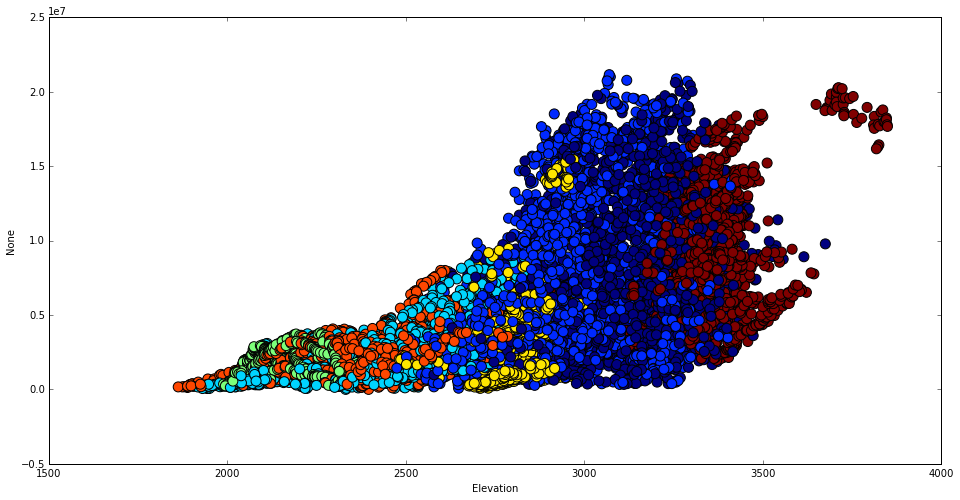

In [179]:
# function to plot data vs classification
def plotc(c1,c2):

    fig = plt.figure(figsize=(16,8))
    sel = np.array(list(train.Cover_Type.values))
    plt.scatter(c1, c2, c=sel, s=100)
    plt.xlabel(c1.name)
    plt.ylabel(c2.name)


plotc(train.Elevation, train.Horizontal_Distance_To_Roadways*train.Elevation)

In [2]:
import itertools
import math

def add_features(train, test=None):
    # feature ideas from blog
    train['EVDtH'] = train.Elevation - train.Vertical_Distance_To_Hydrology
    train['EHDtH'] = train.Elevation - train.Horizontal_Distance_To_Hydrology  
    train['DtH'] = (train['Horizontal_Distance_To_Hydrology']**2 \
                        + train['Vertical_Distance_To_Hydrology']**2)**0.5
    train['Hydro_Fire_1'] = train['Horizontal_Distance_To_Hydrology'] \
                           + train['Horizontal_Distance_To_Fire_Points']
    train['Hydro_Fire_2'] = abs(train['Horizontal_Distance_To_Hydrology'] \
                               - train['Horizontal_Distance_To_Fire_Points'])
    train['Hydro_Road_1'] = abs(train['Horizontal_Distance_To_Hydrology'] \
                               + train['Horizontal_Distance_To_Roadways'])
    train['Hydro_Road_2'] = abs(train['Horizontal_Distance_To_Hydrology'] \
                               - train['Horizontal_Distance_To_Roadways'])
    train['Fire_Road_1'] = abs(train['Horizontal_Distance_To_Fire_Points'] \
                              + train['Horizontal_Distance_To_Roadways'])
    train['Fire_Road_2'] = abs(train['Horizontal_Distance_To_Fire_Points'] \
                              - train['Horizontal_Distance_To_Roadways']) 

    # our ideas
    
    # northernly slopes have substantially less light, high values to be multiplied by slope
    train['south_face'] = [180 - a if a <=180 else a - 180 for a in train.Aspect]

    # the effect of a north facing slope is amplified by steepness of the slope
    train['south_slope'] = train.south_face * train.Slope

    # bin the elevation for generalizability
    elevations = list(np.arange(train.Elevation.min() + 150, train.Elevation.max(), 150))
    elevations.insert(0,-np.inf)
    elevations.append(np.inf)
    train['elev'] = pd.cut(train.Elevation, elevations, labels=False)
    
    # bin the aspect
    aspect3 = [a + 11.5 if a < 348.5 else a - 348.5 for a in train.Aspect]
    angles3 = np.linspace(0,360,17)
    directions3 = ['N','NNE','NE','ENE','E','ESE','SE','SSE',
                   'S','SSW','SW','WSW','W','WNW','NW','NNW']
    train['direction3'] = pd.cut(aspect3, angles3, labels=False)
    
    # horizontal distance to feature (clustering effect)
    train['hdtf'] = train.Horizontal_Distance_To_Hydrology + \
                    train.Horizontal_Distance_To_Roadways + \
                    train.Horizontal_Distance_To_Fire_Points
            
    train['sunlight'] = train.Hillshade_9am + \
                        train.Hillshade_Noon + \
                        train.Hillshade_3pm
          
    train['sunlight_south_slope'] = train.sunlight * (180 - train.south_slope)
    
    # use principle component analysis

#     from sklearn.decomposition import PCA
    
#     soil_columns = [col for col in train.columns if "Soil_Type" in col]
    
#     pca = PCA(n_components=10)
#     soil_pca = pca.fit_transform(train[soil_columns])
#     print pca.explained_variance_
#     print pca.components_
#     for component in pca
#     train.append(
    
    # copy training data into a new object
    new_train = train[:]
#     n_cols = len(train.columns)
#     # create new features that are the interaction of existing features
#     for i in range(n_cols):
#         for j in range(n_cols):
#             if j >= i:
#                 name_i = train.columns[i]
#                 name_j = train.columns[j]
#                 name = name_i + " X " + name_j
#                 new_train[name] = train[name_i] * train[name_j]
    
    new_test = None
    if (test is not None):
        test['EVDtH'] = test.Elevation-test.Vertical_Distance_To_Hydrology
        test['EHDtH'] = test.Elevation-test.Horizontal_Distance_To_Hydrology
        test['DtH'] = (test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)**0.5
        test['Hydro_Fire_1'] = test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points']
        test['Hydro_Fire_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])
        test['Hydro_Road_1'] = abs(test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])
        test['Hydro_Road_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])
        test['Fire_Road_1'] = abs(test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])
        test['Fire_Road_2'] = abs(test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])
        test_aspect3 = [a + 11.5 if a < 348.5 else a - 348.5 for a in test.Aspect]
        test['direction3'] = pd.cut(test_aspect3, angles3, labels=False)
        test['south_face'] = [180 - a if a <=180 else a - 180 for a in test.Aspect]
        test['south_slope'] = test.south_face * test.Slope
        test['elev'] = pd.cut(test.Elevation, elevations, labels=False)
        test['hdtf'] = test.Horizontal_Distance_To_Hydrology + \
                       test.Horizontal_Distance_To_Roadways + \
                       test.Horizontal_Distance_To_Fire_Points
        test['sunlight'] = test.Hillshade_9am + \
                            test.Hillshade_Noon + \
                            test.Hillshade_3pm
        test['sunlight_south_slope'] = test.sunlight * (180 - test.south_slope)
        # copy the test data into a new object
        new_test = test[:]
#         # create new features that are the interaction of existing features
#         for i in range(n_cols):
#             for j in range(n_cols):
#                 if j >= i:
#                     name_i = test.columns[i]
#                     name_j = test.columns[j]
#                     name = name_i + " X " + name_j
#                     new_test[name] = test[name_i] * test[name_j]
        
    return new_train, new_test

In [334]:
from sklearn import ensemble
start = time.time()
# use pandas to read csv
train = pd.read_csv('train.csv')
train_labels = train['Cover_Type'] 
#test = pd.read_csv('test.csv')

feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id',]]

#test = test[feature_cols]
train, _ = add_features(train)
train = train[feature_cols]

def split(data, fraction):
    train = data[:int(len(data)*fraction)]
    dev = data[int(len(data)*fraction):]
    return train, dev
    
# number of times to shuffle data
n_shuffle = 5

# shuffle the dataset and average score over all shuffles and repetitions
scores = []
feature_importance = {col: 0.0 for col in train.columns}
for rep in range(n_shuffle):
    shuffle = np.random.permutation(train.index)
    train.reindex(shuffle)
    train_labels.reindex(shuffle)
    
    X_train, X_dev = split(train, .8)
    y_train, y_dev = split(train_labels, .8)
    
    dt = DecisionTreeClassifier(criterion='entropy')
    dt.fit(X_train, y_train)
    # order features by importance
    important_features = [(i, f) for i,f in sorted(zip(dt.feature_importances_,train.columns),\
                                                   key=lambda x: x[0], reverse=True)]
    for importance, feature in important_features:
        feature_importance[feature] += importance 
    
    scores.append(dt.score(X_dev, y_dev))
    
print np.mean(scores)
print 'Run time:', time.time() - start
sorted_features = list(reversed(sorted(feature_importance, key=feature_importance.get)))
for count, feature in enumerate(sorted_features):
    print count, feature_importance[feature], feature

0.785978835979
Run time: 0.979876995087
0 2.71868891538 Elevation
1 0.417260050369 Horizontal_Distance_To_Roadways
2 0.332540399987 Horizontal_Distance_To_Fire_Points
3 0.231160125346 Hillshade_9am
4 0.20928918321 Horizontal_Distance_To_Hydrology
5 0.16177596713 Hillshade_Noon
6 0.153765814052 Vertical_Distance_To_Hydrology
7 0.110300019391 Aspect
8 0.0982803494657 Wilderness_Area1
9 0.0831411453763 Hillshade_3pm
10 0.0815050505596 Slope
11 0.0701961525808 Wilderness_Area3
12 0.0497302065317 Soil_Type3
13 0.0438091703828 Soil_Type10
14 0.0424707266835 Soil_Type4
15 0.0207383738121 Soil_Type2
16 0.0195548423599 Soil_Type39
17 0.0180458459749 Soil_Type32
18 0.0146126040915 Soil_Type12
19 0.0109998207611 Soil_Type29
20 0.0103613569935 Soil_Type23
21 0.0102884912657 Soil_Type17
22 0.00974555352702 Soil_Type38
23 0.00862476768738 Soil_Type33
24 0.00832087823823 Soil_Type30
25 0.00721014744786 Wilderness_Area4
26 0.00691796371726 Soil_Type13
27 0.00687870975508 Soil_Type31
28 0.0064912623312

In [124]:
train = pd.read_csv('train.csv')
train_labels = train['Cover_Type']
#test = pd.read_csv('test.csv')

In [ ]:
# shuffle the dataset to find the most important features

from sklearn import ensemble
start = time.time()
# use pandas to read csv
train = pd.read_csv('train.csv')
train_labels = train['Cover_Type'] 
#test = pd.read_csv('test.csv')

# columns to exclude
exclude_cols = ['directions3',
                'south_slope',
                'south_face',
                #'elev',
                #'hdtf'
                'sunlight'
                'sunlight_south_slope'
               ]

feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id',] \
                and col not in exclude_cols]

#test = test[feature_cols]
train, _ = add_features(train)
train = train[feature_cols]

def split(data, fraction):
    train = data[:int(len(data)*fraction)]
    dev = data[int(len(data)*fraction):]
    return train, dev
    
# number of times to shuffle data
n_shuffle = 5

# shuffle the dataset and average score over all shuffles and repetitions
scores = []
feature_importance = {col: 0.0 for col in train.columns}
for rep in range(n_shuffle):
    shuffle = np.random.permutation(train.index)
    train.reindex(shuffle)
    train_labels.reindex(shuffle)
    
    X_train, X_dev = split(train, .8)
    y_train, y_dev = split(train_labels, .8)
    
    dt = DecisionTreeClassifier(criterion='entropy')
    dt.fit(X_train, y_train)
    # order features by importance
    important_features = [(i, f) for i,f in sorted(zip(dt.feature_importances_,train.columns), \
                                                   key=lambda x: x[0], reverse=True)]
    for importance, feature in important_features:
        feature_importance[feature] += importance 
    
    scores.append(dt.score(X_dev, y_dev))
    
print np.mean(scores)
print 'Run time:', time.time() - start
sorted_features = list(reversed(sorted(feature_importance, key=feature_importance.get)))
for count, feature in enumerate(sorted_features):
    print count, feature_importance[feature], feature

In [66]:
# find the best number of interaction features to keep, possibly 0...

feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id',] \
                and col not in exclude_cols]
train = train[feature_cols]
#test = test[feature_cols]
train, _ = add_features(train)

scores = []
for i in range(60, 100):
    top_features = sorted_features[:i]
    X_train = train[top_features]
    #test = test[top_features]

    X_train, X_dev = split(X_train, .5)
    y_train, y_dev = split(train_labels, .5)

    forest = ensemble.ExtraTreesClassifier(n_estimators=400, 
                                           criterion='gini', 
                                           max_depth=None, 
                                           min_samples_split=2, 
                                           min_samples_leaf=1, 
                                           max_features='auto', 
                                           bootstrap=False, 
                                           oob_score=False, 
                                           n_jobs=-1, 
                                           random_state=None, 
                                           verbose=0) 
                                           #min_density=None)

    forest.fit(X_train, y_train)
    scores.append((i, forest.score(X_dev, y_dev)))


    print scores

[(60, 0.71309523809523812), (61, 0.71124338624338623), (62, 0.71005291005291005), (63, 0.71891534391534395), (64, 0.71706349206349207), (65, 0.72222222222222221), (66, 0.71812169312169316), (67, 0.71772486772486777), (68, 0.71640211640211637), (69, 0.71494708994709), (70, 0.71613756613756618), (71, 0.71865079365079365), (72, 0.71931216931216935), (73, 0.71653439153439158), (74, 0.71243386243386242), (75, 0.72208994708994712), (76, 0.70925925925925926), (77, 0.71785714285714286), (78, 0.70873015873015877), (79, 0.71203703703703702), (80, 0.72010582010582014), (81, 0.71944444444444444), (82, 0.71164021164021163), (83, 0.71296296296296291), (84, 0.72182539682539681), (85, 0.71600529100529098), (86, 0.71732804232804237), (87, 0.70859788359788356), (88, 0.71375661375661381), (89, 0.71243386243386242), (90, 0.71203703703703702), (91, 0.71216931216931212), (92, 0.7144179894179894), (93, 0.71349206349206351), (94, 0.71388888888888891), (95, 0.71679894179894177), (96, 0.70886243386243386), (97,

In [113]:
# grid search over extratreesclassifier

from sklearn.ensemble import ExtraTreesClassifier

start = time.time()

# columns to exclude
exclude_cols = [
#                 'directions3',
#                 'south_slope',
#                 'south_face',
#                 'elev',
#                 'hdtf'
#                 'sunlight'
#                 'sunlight_south_slope'
               ]

feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id',] \
                and col not in exclude_cols]

train, _ = add_features(train)
train = train[feature_cols]


shuffle = np.random.permutation(train.index)
train.reindex(shuffle)
train_labels.reindex(shuffle)
    
def split(data, fraction):
    train = data[:int(len(data)*fraction)]
    dev = data[int(len(data)*fraction):]
    return train, dev

X_train, X_dev = split(train, .8)
y_train, y_dev = split(train_labels, .8)

params = {#'n_estimators':[15,17,19,21,23,25,27], 
          #'min_samples_split':np.arange(2,5),
          #'max_features':np.arange(5, 33)
          #'max_depth':np.arange(15,25)
          }

clf = GridSearchCV(ExtraTreesClassifier(criterion='gini', 
                                        max_depth=None,  
                                        min_samples_leaf=1,  
                                        bootstrap=False, 
                                        oob_score=False, 
                                        n_jobs=-1, 
                                        random_state=None, 
                                        verbose=0, 
                                        min_samples_split=2,
                                        n_estimators=300,
                                        max_features='auto'
                                        ),params)
clf.fit(X_train, y_train)
print clf.best_score_
print clf.best_params_
print clf.score(X_dev, y_dev)
print clf.grid_scores_

# forest = ExtraTreesClassifier(n_estimators=50, 
#                               criterion='entropy', 
#                               max_depth=None, 
#                               min_samples_split=2, 
#                               min_samples_leaf=1, 
#                               max_features=None, 
#                               bootstrap=False, 
#                               oob_score=False, 
#                               n_jobs=-1, 
#                               random_state=None, 
#                               verbose=0) 
#                               #min_density=None)

# forest.fit(X_train, y_train)
# print forest.score(X_dev, y_dev)

0.62144510582
{}
0.860119047619
[mean: 0.62145, std: 0.04721, params: {}]


In [358]:


# use pandas to read csv
train = pd.read_csv('train.csv')
train_labels = train['Cover_Type'] 
#test = pd.read_csv('test.csv')
original_cols = [col for col in train.columns if col not in ['Cover_Type','Id']]
train, _ = add_features(train)
feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id']]
train = train[feature_cols]

all_features = ['Elevation', 'Wilderness_Area4', 
                'Horizontal_Distance_To_Roadways', 
                'Horizontal_Distance_To_Hydrology', 
                'Horizontal_Distance_To_Fire_Points', 'Soil_Type10', 
                'Wilderness_Area1', 'Vertical_Distance_To_Hydrology',
                'Hillshade_9am', 'Soil_Type3', 'Wilderness_Area3', 
                 'Aspect', 'Hillshade_3pm', 
                'Soil_Type38', 'Soil_Type39', 'Slope', 'Hillshade_Noon', 
                'Soil_Type30', 'Soil_Type4', 'Soil_Type40', 'Soil_Type17', 
                'Soil_Type2', 'Soil_Type29', 'Soil_Type13', 'Soil_Type23', 'Soil_Type12', 
                'Soil_Type32', 'Soil_Type22', 'Soil_Type6', 'Soil_Type33', 'Soil_Type11', 
                'Wilderness_Area2', 'Soil_Type31', 'Soil_Type24', 'Soil_Type1', 
                'Soil_Type35', 'Soil_Type20', 'Soil_Type14', 'Soil_Type5', 'Soil_Type16', 
                'Soil_Type18', 'Soil_Type19', 'Soil_Type37', 'Soil_Type26', 'Soil_Type34', 
                'Soil_Type21', 'Soil_Type28', 'Soil_Type27', 'Soil_Type36', 'Soil_Type9', 
                'Soil_Type25', 'Soil_Type8', 'Soil_Type7', 'Soil_Type15',
                'EVDtH', 
                'DtH',
#                 'Fire_Road_2',
#                 'EHDtH',
#                 'Hydro_Road_2', 
#                 'Fire_Road_1', 
#                 'hdtf', 
#                 'Hydro_Road_1', 
#                 'Hydro_Fire_1', 
#                 'Hydro_Fire_2', 
#                 'south_face', 
#                 'sunlight_south_slope', 
#                 'south_slope', 
#                 'direction3', 
#                 'sunlight'
               ]

all_features = np.asarray(all_features)

pandas.core.index.Index

In [3]:
# shuffle and split data set

def split_data(data, fraction):
    data_labels = data['Cover_Type']
    
    feature_cols = [col for col in data.columns if col not in ['Cover_Type', 'Id']]
    data = data[feature_cols]
    shuffle = np.random.permutation(data.index)
    data.reindex(shuffle)
    data_labels.reindex(shuffle)
    
    split = int(len(data)*fraction)
    
    train = data[:split]
    train_labels = data_labels[:split]
    dev = data[split:]
    dev_labels = data_labels[split:]
    return train, train_labels, dev, dev_labels

0.864087301587
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'EVDtH', 'EHDtH', 'south_face', 'direction3', 'sunlight']
0.867394179894


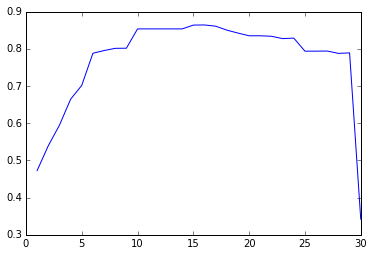

In [4]:
# figure out which features to use with nearest neighbors

# need to shuffle columns!!!!
train = pd.read_csv('train.csv')

minus_soil_feats = [col for col in train.columns if "Soil_Type" not in col]
train = train[minus_soil_feats]

train, _ = add_features(train)
X_train, y_train, X_dev, y_dev = split_data(train,.8)

cols = X_train.columns
knn = KNeighborsClassifier(n_neighbors=1)
scores = []
for n in range(1,len(cols)+1):
    knn.fit(X_train[cols[0:n]],y_train)
    score = knn.score(X_dev[cols[0:n]], y_dev)
    scores.append(score)

plt.plot(range(1,len(cols)+1), scores)

print max(scores)
cols_to_keep = ['Elevation']
for i in range(len(scores)-1):
    if scores[i+1] - scores[i] > 0:
        cols_to_keep.append(cols[i + 1])

print cols_to_keep

knn.fit(X_train[cols_to_keep], y_train)
print knn.score(X_dev[cols_to_keep], y_dev)

In [21]:
# scale data to zero mean and unit variance
def standardize(train, dev, test=None):
    scaler = StandardScaler().fit(train)
    X_train_std = scaler.transform(train)
    X_dev_std = scaler.transform(dev)
    X_test_std = None
    if test is not None:
        X_test_std = scaler.transform(test)
    return X_train_std, X_dev_std, X_test_std

In [ ]:
# grid search to find best parameters for support vector machine

# possibly add a graph like a confusion matrix to show gamma vs C or 
# decision boundary
from sklearn.svm import SVC
import datetime

start = time.time()

train = pd.read_csv('train.csv')
# minus_soil_feats = [col for col in train.columns if "Soil_Type" not in col]
# train = train[minus_soil_feats]
train, _ = add_features(train)
X_train, y_train, X_dev, y_dev = split_data(train,.8)
X_train, X_dev, _ = standardize(X_train.as_matrix(), X_dev.as_matrix())

params = { 'C':10.**np.arange(-2,5), 'gamma':10.**np.arange(-5,4) }

clf = GridSearchCV( SVC(kernel='rbf'),params)
clf.fit(X_train, y_train)
print clf.best_score_
print clf.best_params_
print clf.score(X_dev, y_dev)
print clf.grid_scores_
print 'Run time = %s' % (datetime(timedelta(seconds=time.time() - start)))

In [ ]:
start = time.time()

train = pd.read_csv('train.csv')
# minus_soil_feats = [col for col in train.columns if "Soil_Type" not in col]
# train = train[minus_soil_feats]
train, _ = add_features(train)
X_train, y_train, X_dev, y_dev = split_data(train,.8)
X_train, X_dev, _ = standardize(X_train.as_matrix(), X_dev.as_matrix())

params = { 'C':10.**np.arange(-2,5) }

clf = GridSearchCV( SVC(kernel='linear'),params)
clf.fit(X_train, y_train)
print clf.best_score_
print clf.best_params_
print clf.score(X_dev, y_dev)
print clf.grid_scores_
print 'Run time = %s' % (datetime(timedelta(seconds=time.time() - start)))

###Create a custom ensemble

In [11]:
# combine estimators to get better result


from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
start = time.time()

# shuffle the dataset and average results over all shuffles and repetitions
scores = []
split = .8
n_shuffle = 1

for rep in range(n_shuffle):
    X_train, y_train, X_dev, y_dev = split_data(train, split)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train[cols_to_keep], y_train)
    knn_pred = knn.predict(X_dev[cols_to_keep])
                                     
    etc = ExtraTreesClassifier(criterion='gini', 
                                max_depth=None,  
                                min_samples_leaf=1,  
                                bootstrap=False, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=None, 
                                verbose=0, 
                                min_samples_split=2,
                                n_estimators=400,
                                max_features='auto'
                                )
    etc.fit(X_train, y_train)
    etc_pred = etc.predict(X_dev)
    
    X_train_s, X_dev_s = standardize(X_train.as_matrix(), X_dev.as_matrix())
    lsv = SVC(kernel='linear', C=1)
    lsv.fit(X_train_s, y_train)
    lsv_pred = lsv.predict(X_dev_s)
    
    rsv = SVC(gamma=2)
    rsv.fit(X_train_s, y_train)
    rsv_pred = rsv.predict(X_dev_s)
    
    # see how good each classifier does
    print knn.score(X_dev[cols_to_keep], y_dev)
    print etc.score(X_dev, y_dev)
    print lsv.score(X_dev_s, y_dev)
    print rsv.score(X_dev_s, y_dev)
    print 'Time = %.2f seconds' % (time.time() - start)
    

for i in range(len(X_dev)):
    print "%s %s %s %s \t %s" % (knn_pred[i], etc_pred[i], lsv_pred[i], rsv_pred[i], \
                            y_dev.get_values()[i])

final_pred = []
for pred in range(len(X_dev)):
    

0.867394179894
0.884259259259
0.707341269841
0.686177248677
Time = 32.01 seconds
5 5 5 5 	 5
2 2 5 2 	 1
2 5 5 2 	 2
5 2 5 2 	 2
6 6 6 6 	 6
3 3 4 3 	 3
3 3 4 3 	 3
6 6 4 6 	 6
6 6 3 6 	 6
5 5 5 5 	 5
5 5 2 5 	 5
6 6 5 6 	 6
4 4 4 4 	 4
6 6 3 6 	 6
6 6 3 6 	 6
5 5 5 5 	 5
6 6 2 6 	 6
6 3 3 3 	 3
6 6 4 2 	 6
5 5 5 2 	 5
6 6 6 6 	 6
6 6 6 6 	 6
6 6 3 2 	 6
5 5 5 2 	 5
5 5 5 5 	 5
5 5 5 5 	 5
5 5 5 5 	 5
5 5 2 5 	 5
2 2 2 2 	 6
4 4 4 4 	 4
3 6 4 6 	 6
6 3 4 2 	 6
6 6 3 2 	 6
5 5 5 5 	 5
5 5 5 5 	 5
5 5 5 5 	 5
5 5 5 5 	 5
5 5 5 5 	 5
5 5 5 5 	 5
5 5 5 5 	 5
5 5 5 5 	 5
6 6 5 6 	 6
6 6 6 6 	 3
3 3 3 3 	 3
6 3 4 3 	 6
6 6 3 6 	 6
3 3 4 3 	 3
5 5 5 5 	 5
5 5 5 5 	 5
5 5 5 5 	 5
5 5 5 5 	 5
3 3 3 3 	 3
3 3 4 2 	 3
6 6 6 2 	 6
6 3 4 2 	 3
2 2 2 2 	 1
5 5 5 2 	 5
5 5 5 5 	 5
5 5 6 5 	 5
5 5 5 5 	 5
5 5 5 5 	 5
6 6 3 6 	 6
6 6 6 2 	 6
5 5 5 2 	 5
5 5 5 5 	 5
5 5 5 5 	 5
5 5 5 5 	 5
6 6 5 6 	 6
6 6 6 2 	 6
5 5 5 2 	 5
5 5 5 5 	 5
5 5 5 5 	 5
5 5 5 5 	 5
6 6 6 3 	 6
4 4 4 4 	 4
6 6 3 2 	 6
6 6 4 2

Deleted code to find the optimal number of features to keep by iterating over top features and repeatedly fitting and scoring

In [232]:
print top_features

['Elevation', 'EVDtH', 'EHDtH', 'Wilderness_Area4', 'Hydro_Road_2', 'Fire_Road_1', 'hdtf', 'Horizontal_Distance_To_Roadways', 'Hydro_Road_1', 'Horizontal_Distance_To_Hydrology', 'DtH', 'Hydro_Fire_1', 'Horizontal_Distance_To_Fire_Points', 'Fire_Road_2', 'Soil_Type10', 'Hydro_Fire_2', 'Wilderness_Area1', 'Vertical_Distance_To_Hydrology', 'Hillshade_9am', 'Soil_Type3', 'Wilderness_Area3', 'south_face', 'sunlight_south_slope', 'Aspect', 'Hillshade_3pm', 'south_slope', 'direction3', 'Soil_Type38', 'Soil_Type39', 'Slope', 'Hillshade_Noon', 'sunlight', 'Soil_Type30', 'Soil_Type4', 'Soil_Type40', 'Soil_Type17', 'Soil_Type2', 'Soil_Type29', 'Soil_Type13', 'Soil_Type23', 'Soil_Type12', 'Soil_Type32', 'Soil_Type22', 'Soil_Type6', 'Soil_Type33', 'Soil_Type11', 'Wilderness_Area2', 'Soil_Type31', 'Soil_Type24', 'Soil_Type1', 'Soil_Type35', 'Soil_Type20', 'Soil_Type14', 'Soil_Type5', 'Soil_Type16', 'Soil_Type18', 'Soil_Type19', 'Soil_Type37', 'Soil_Type26', 'Soil_Type34', 'Soil_Type21', 'Soil_Type28

In [56]:
from sklearn.ensemble import ExtraTreesClassifier
# make a prediction
train = pd.read_csv('train.csv')
train_labels = train['Cover_Type']
test = pd.read_csv('test.csv')
test_ids = test['Id']
original = train.columns
#top_features = sorted_features[:10]
feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id',]]
train = train[feature_cols]
test = test[feature_cols]
train, test = add_features(train, test)
custom_cols = ['EVDtH', 'EHDtH','DtH','Hydro_Fire_1','Hydro_Fire_2','Hydro_Road_1',
               'Hydro_Road_2','Fire_Road_1','Fire_Road_2','direction3','south_face',
               'south_slope','sunlight','sunlight_south_slope',
               #'elev','hdtf'
              ]
feature_cols = [col for col in train.columns if col in original #or col in top_features
                or col in custom_cols]
train, test = train[feature_cols], test[feature_cols]

train = train[feature_cols]
test = test[feature_cols]

forest = ExtraTreesClassifier(n_estimators=400, 
                              max_features='auto',
                              min_samples_split=2,
                              criterion='gini', 
                              max_depth=None, 
                              min_samples_leaf=1,  
                              bootstrap=False, 
                              oob_score=False, 
                              n_jobs=-1, 
                              random_state=None, 
                              verbose=0)
forest.fit(train, train_labels)
predictions = forest.predict(test)

with open("predictions.csv", "wb") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Id','Cover_Type'])
    for id, prediction in zip(test_ids, predictions):
        writer.writerow([int(id), int(prediction)])

In [7]:
print top_features

['EVDtH', 'Elevation X EVDtH', 'EVDtH X EVDtH', 'Hillshade_9am X Wilderness_Area4', 'EVDtH X elev', 'Wilderness_Area1 X Hydro_Road_1', 'EVDtH X EHDtH', 'EVDtH X DtH', 'Wilderness_Area3 X south_slope', 'Fire_Road_2 X elev']


In [53]:
pd.DataFrame(forest.feature_importances_,index=X_train.columns).sort([0], ascending=False) [:20]

,0
Elevation,0.154497
Horizontal_Distance_To_Roadways,0.081567
Horizontal_Distance_To_Fire_Points,0.066686
Wilderness_Area4,0.065365
Horizontal_Distance_To_Hydrology,0.059317
Vertical_Distance_To_Hydrology,0.051640
Hillshade_9am,0.051190
Aspect,0.050173
Hillshade_3pm,0.046250
Hillshade_Noon,0.045980


In [ ]:
#with open('features_engineering_benchmark.csv', "wb") as outfile:
#    outfile.write("Id,Cover_Type\n")
#    for e, val in enumerate(list(forest.predict(X_test))):
#        outfile.write("%s,%s\n"%(test_ids[e],val))

In [7]:
# feature engineering
import itertools
import math

# Create a feature that represents the cardinal direction of the slope
# aspect = [a + 45 if a < 315 else a - 315 for a in train.Aspect]
# dev_aspect = [a + 45 if a < 315 else a - 315 for a in dev.Aspect]
# angles = [-1,90,180,270,360]
# directions = ['N','E','S','W']
# aspect2 = [a + 22.5 if a < 337.5 else a - 337.5 for a in train.Aspect]
# dev_aspect2 = [a + 22.5 if a < 337.5 else a - 337.5 for a in dev.Aspect]
# angles2 = np.linspace(0,360,9)
# directions2 = ['N','NE','E','SE','S','SW','W','NW']
aspect3 = [a + 11.5 if a < 348.5 else a - 348.5 for a in train.Aspect]
dev_aspect3 = [a + 11.5 if a < 348.5 else a - 348.5 for a in dev.Aspect]
angles3 = np.linspace(0,360,17)
directions3 = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW']

# train['direction'] = pd.cut(aspect, angles, labels=False)
# dev['direction'] = pd.cut(dev_aspect, angles, labels=False)
# train['direction2'] = pd.cut(aspect2, angles2, labels=False)
# dev['direction2'] = pd.cut(dev_aspect2, angles2, labels=False)
train['direction3'] = pd.cut(aspect3, angles3, labels=False)
dev['direction3'] = pd.cut(dev_aspect3, angles3, labels=False)

# # look at horizontal distance from points of interest
# train['avg_hrz_dist'] = (train.Horizontal_Distance_To_Hydrology + \
#                          train.Horizontal_Distance_To_Roadways + \
#                          train.Horizontal_Distance_To_Fire_Points) / 3
# dev['avg_hrz_dist'] = (dev.Horizontal_Distance_To_Hydrology + \
#                        dev.Horizontal_Distance_To_Roadways + \
#                        dev.Horizontal_Distance_To_Fire_Points) / 3

# northernly slopes have substantially less light, high values to be multiplied by slope
train['south_face'] = [180 - a if a <=180 else a - 180 for a in train.Aspect]
dev['south_face'] = [180 - a if a <=180 else a - 180 for a in dev.Aspect]

# the effect of a north facing slope is amplified by steepness of the slope
train['south_slope'] = train.south_face * train.Slope
dev['south_slope'] = dev.south_face * dev.Slope

# bin the elevation
elevations = list(np.arange(train.Elevation.min() + 50, train.Elevation.max(), 50))
elevations.insert(0,-np.inf)
elevations.append(np.inf)
train['elev'] = pd.cut(train.Elevation, elevations, labels=False)
dev['elev'] = pd.cut(dev.Elevation, elevations, labels=False)

# # prepare data set to be used with classifier, remove columns that won't be used for prediction
# features = [c for c in train.columns if c not in ['Cover_Type','Id','Aspect','Slope','elev']]
# X = train[features]
# y = train['Cover_Type']
# ids = train['Id']
# dev_X = dev[features]
# dev_y = dev['Cover_Type']
# dev_ids = dev['Id']

# # scaler = StandardScaler().fit(X)
# # X = scaler.transform(X)
# # dev_X = scaler.transform(dev_X)

# # Feature selection using a decision tree
# dt = DecisionTreeClassifier()
# dt.fit(X, y)
# print dt.score(dev_X, dev_y)

In [21]:
# Run the prediction several times to reduce variability, exclude different sets of columns

scores = []
exclude_cols = []
# generate all combinations of the following columns 
columns = ['Aspect','Elevation','Slope','south_slope',
           'south_face','elev','direction','direction2',
           'direction3']
for l in range(len(columns) + 1):
    for subset in itertools.combinations(columns, l):
        exclude_cols.append(subset)

# test all combinations of columns to see what works best
for i in range(len(exclude_cols)):
    temp_scores = []
    for rep in range(1):
        # prepare data set to be used with classifier, remove columns that won't be used for prediction
        features = [c for c in train.columns if c not in ['Cover_Type','Id'] and c not in exclude_cols[i]]
        X = train[features]
        y = train['Cover_Type']
        ids = train['Id']
        dev_X = dev[features]
        dev_y = dev['Cover_Type']
        dev_ids = dev['Id']

        # scaler = StandardScaler().fit(X)
        # X = scaler.transform(X)
        # dev_X = scaler.transform(dev_X)

        # Feature selection using a decision tree
        dt = DecisionTreeClassifier(criterion='entropy')
        dt.fit(X, y)
        temp_scores.append(dt.score(dev_X, dev_y))
    scores.append(np.mean(temp_scores))

for xcols, score in sorted(zip(exclude_cols, scores),key=lambda x:x[1], reverse=True):
    print 'Score = %.4f excluding %s' % (score, xcols)

# # print out the tree for visual inspection
#export_graphviz(dt, out_file='tree.dot')

# # order features by importance in tree
# important_features = [(i, f) for i,f in sorted(zip(dt.feature_importances_,features), \
#                                                key=lambda x: x[0], reverse=True)]
# for importance, feature in important_features:
#     print "%6.4f %s" % (importance, feature) 

Score = 0.6452 excluding ('Aspect', 'Elevation', 'direction', 'direction2', 'direction3')
Score = 0.6451 excluding ('Aspect', 'Elevation', 'Slope', 'south_slope', 'south_face', 'elev', 'direction2')
Score = 0.6447 excluding ('Elevation', 'Slope', 'south_slope', 'direction2', 'direction3')
Score = 0.6437 excluding ('Elevation', 'Slope', 'south_face', 'elev', 'direction2')
Score = 0.6431 excluding ('Aspect', 'Elevation', 'south_slope', 'elev', 'direction2', 'direction3')
Score = 0.6427 excluding ('Aspect', 'Elevation', 'Slope', 'south_slope', 'direction3')
Score = 0.6427 excluding ('Elevation', 'Slope', 'south_slope', 'south_face', 'direction2')
Score = 0.6426 excluding ('Aspect', 'Elevation', 'Slope', 'south_face', 'elev', 'direction2')
Score = 0.6425 excluding ('Aspect', 'Elevation', 'Slope', 'south_slope', 'elev', 'direction')
Score = 0.6419 excluding ('Elevation', 'south_face', 'elev')
Score = 0.6417 excluding ('Elevation', 'south_slope', 'elev', 'direction3')
Score = 0.6414 excludin

The best results were obtained by excluding 'Elevation', 'Slope', 'south_face', 'direction', 'direction2'. Excluding Slope improved the results trivially, as well as keeping Aspect. These would be good targets for binning. It looks like we see just over a 4% increase so far with the engineered features.

In [503]:
# test different values for binning the elevation
scores = []
cuts = np.arange(1,200,5)
for cut in cuts:
    cut_scores = []
    for rep in range(10):
        # elevation cuts

        elevations = list(np.arange(train.Elevation.min() + 100, train.Elevation.max(), 50))
        elevations.insert(0,-np.inf)
        elevations.append(np.inf)
        train['elev'] = pd.cut(train.Elevation, elevations, labels=False)
        dev['elev'] = pd.cut(dev.Elevation, elevations, labels=False)

        # prepare data set to be used with classifier, remove columns that won't be used for prediction
        features = [c for c in train.columns if c not in ['Cover_Type','Id','Elevation']]
        X = train[features]
        y = train['Cover_Type']
        ids = train['Id']
        dev_X = dev[features]
        dev_y = dev['Cover_Type']
        dev_ids = dev['Id']

        # scaler = StandardScaler().fit(X)
        # X = scaler.transform(X)
        # dev_X = scaler.transform(dev_X)

        # Feature selection using a decision tree
        dt = DecisionTreeClassifier()
        dt.fit(X, y)
        cut_scores.append(dt.score(dev_X, dev_y))
    scores.append(np.mean(cut_scores))
for cut,score in sorted(zip(cuts,scores),key=lambda x: x[1], reverse=True):
    print "%4s %.4f" % (cut,score)


 106 0.6234
  66 0.6229
  56 0.6221
  91 0.6215
 136 0.6204
  86 0.6202
 126 0.6200
  96 0.6196
  76 0.6192
 191 0.6191
  16 0.6190
  46 0.6190
  21 0.6189
  11 0.6189
 111 0.6188
  81 0.6187
 161 0.6186
 131 0.6184
 121 0.6183
  71 0.6179
  51 0.6178
 141 0.6175
 101 0.6174
 181 0.6174
   6 0.6172
   1 0.6172
  26 0.6171
 196 0.6170
 166 0.6170
 186 0.6169
 156 0.6168
 151 0.6167
  31 0.6165
  36 0.6161
  61 0.6146
  41 0.6145
 176 0.6140
 116 0.6136
 171 0.6124
 146 0.6121
